### Trying to create a model for MA school district data for Massachusetts.
- Used the combined data from 2018-19 to 2022-23.
- "School District" is labeled as "County" in our dataset for consistency with other two states.
- For 2018-19 academic year, used the population and income data for the year 2018, and so on.
- Income and population data retrieved from the CAINC1 data file released by bea.gov.
- Used geopy to compute the average distance between counties and university. We take the five closest universities to compute the average distance.
### Also did statistical analysis with statsmodels
- Percentage of 3 or above score (AKA pass rate) is used as the target variable.
- Per capita income, population and average distance to five closest R1R2, public, private (not for profit), stem and landgrant universities, as well as average enrollment in them are used as features.
- Full model includes all features.
- Uni metric model includes the 15 university related metrics as features.
- Non-uni model includes per capita and population as features.
- The p-values are all small. Might be reflective of the fact that none of the features are very accurate at predicting the pass rates, so adding more features makes some improvements to the models.
### Also did modelling with sklearn and xgboost
- Considered the ordinary least squares (OLS) linear regression (with aforementioned three types of models), PCA-then-linear-regression model (with n-components = 0.95) and Ridge model.
- The PCA reduced the 17 features to 9 when set n-components=0.95.
- Did 5-fold cross validation, and compared the average root mean square errors (rmse) of the models.
- Xgboost has the lowest average rmse, followed by Ridge and full model with sklearn.
- Also created the summary plots with shap.
### Summarizing RMSE's on 5-Fold cross-validation of various models:
- Baseline model: 17.390
- OLS full model (sklearn): 12.496
- Ridge model (sklearn): 12.514
- PCA(0.95) model (sklearn): 12.607
- Xgboost model with full features: 9.0780
- Adaboost model with full features: 10.710
- Random forest with full features: 9.169
### Summarizing R-squared scores on 5-Fold cross-validation of various models:
- Baseline model: 0.000
- OLS full model (sklearn): 0.483
- Ridge model (sklearn): 0.482
- PCA(0.95) model (sklearn): 0.474
- Xgboost model with full features: 0.725
- Adaboost model with full features: 0.620
- Random forest with full features: 0.721
### In the end, we run our model of choice (Random Forest) on the testing data.
- The RMSE of our prediction is 8.619.
- The $R^2$-coefficient of our prediction is 0.643.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

In [2]:
training = pd.read_csv('../data/Massachusetts/train_test_split/training.csv')

In [3]:
training

,COUNTY,District Code,Year,Tests Taken,PERCENT_3_OR_ABOVE,population,per_capita_income,closest_five_r1r2_avg,closest_five_avg_enrollment_r1r2,closest_five_avg_dormrooms_r1r2,...,closest_five_avg_dormrooms_public,closest_five_private_nfp_avg,closest_five_avg_enrollment_private_nfp,closest_five_avg_dormrooms_private_nfp,closest_five_landgrnt_avg,closest_five_avg_enrollment_landgrnt,closest_five_avg_dormrooms_landgrant,closest_five_stem_avg,closest_five_avg_enrollment_stem,closest_five_avg_dormrooms_stem
0,Pembroke,2310000,2020,388,60.8,18330,140052,23.398174,28875.2,8259.6,...,876.2,18.102141,1762.8,863.6,60.764228,19024.6,7667.8,23.398174,28875.2,8259.6
1,Lunenburg,1620000,2021,152,78.9,11735,106138,25.932175,10717.4,3109.4,...,347.4,16.956028,1225.4,187.2,49.964060,21959.2,9148.8,23.665935,8281.4,2295.4
2,Winchendon,3430000,2022,53,50.9,10372,84375,35.713399,15182.0,5098.4,...,1169.8,16.039691,1753.4,650.4,55.367389,21959.2,9148.8,32.858763,14157.0,4508.4
3,Saugus,2620000,2022,270,43.3,28566,96064,7.995680,27745.4,8858.2,...,640.2,6.144916,3335.4,409.0,50.308503,20217.2,8062.8,7.995680,27745.4,8858.2
4,Triton,7730000,2019,178,71.9,22080,121891,25.708019,21735.2,7255.0,...,1413.8,11.018576,3821.8,1360.0,52.029134,20217.2,8062.8,25.708019,21735.2,7255.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
883,Greenfield,1140000,2022,96,59.4,17674,53149,43.998982,17077.8,6745.0,...,3418.2,18.837345,661.0,696.2,67.053015,21959.2,9148.8,42.165769,11369.8,4337.0
884,Billerica,310000,2018,447,70.7,41708,134805,13.041963,19915.8,6622.4,...,1141.2,11.502871,4178.8,1579.6,48.131279,21959.2,9148.8,13.041963,19915.8,6622.4
885,Marblehead,1680000,2022,677,69.4,20350,164104,14.829929,23157.4,6963.4,...,855.6,7.210064,2628.6,907.6,53.155006,20217.2,8062.8,14.829929,23157.4,6963.4
886,Falmouth,960000,2021,311,65.6,32694,89809,46.220849,18103.2,5323.4,...,1787.0,38.106051,3223.4,1681.2,83.060442,19024.6,7667.8,46.220849,18103.2,5323.4


In [4]:
features = list(training.columns[5:])
features

['population',
 'per_capita_income',
 'closest_five_r1r2_avg',
 'closest_five_avg_enrollment_r1r2',
 'closest_five_avg_dormrooms_r1r2',
 'closest_five_public_avg',
 'closest_five_avg_enrollment_public',
 'closest_five_avg_dormrooms_public',
 'closest_five_private_nfp_avg',
 'closest_five_avg_enrollment_private_nfp',
 'closest_five_avg_dormrooms_private_nfp',
 'closest_five_landgrnt_avg',
 'closest_five_avg_enrollment_landgrnt',
 'closest_five_avg_dormrooms_landgrant',
 'closest_five_stem_avg',
 'closest_five_avg_enrollment_stem',
 'closest_five_avg_dormrooms_stem']

In [5]:
from sklearn.model_selection import train_test_split
train, validation = train_test_split(training, test_size = 0.2, random_state = 226)

### Let's do some statistical analysis with statsmodels

In [6]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [7]:
x_train = training.drop(['COUNTY','District Code','Year','Tests Taken'],axis=1)
y_train = training[['PERCENT_3_OR_ABOVE']]
X_train = sm.add_constant(x_train)
unimetric_train = X_train.drop(['population','per_capita_income'],axis=1)
X_train

,const,PERCENT_3_OR_ABOVE,population,per_capita_income,closest_five_r1r2_avg,closest_five_avg_enrollment_r1r2,closest_five_avg_dormrooms_r1r2,closest_five_public_avg,closest_five_avg_enrollment_public,closest_five_avg_dormrooms_public,closest_five_private_nfp_avg,closest_five_avg_enrollment_private_nfp,closest_five_avg_dormrooms_private_nfp,closest_five_landgrnt_avg,closest_five_avg_enrollment_landgrnt,closest_five_avg_dormrooms_landgrant,closest_five_stem_avg,closest_five_avg_enrollment_stem,closest_five_avg_dormrooms_stem
0,1.0,60.8,18330,140052,23.398174,28875.2,8259.6,16.327567,9990.2,876.2,18.102141,1762.8,863.6,60.764228,19024.6,7667.8,23.398174,28875.2,8259.6
1,1.0,78.9,11735,106138,25.932175,10717.4,3109.4,14.146094,6440.8,347.4,16.956028,1225.4,187.2,49.964060,21959.2,9148.8,23.665935,8281.4,2295.4
2,1.0,50.9,10372,84375,35.713399,15182.0,5098.4,18.138275,5317.4,1169.8,16.039691,1753.4,650.4,55.367389,21959.2,9148.8,32.858763,14157.0,4508.4
3,1.0,43.3,28566,96064,7.995680,27745.4,8858.2,8.433691,7679.8,640.2,6.144916,3335.4,409.0,50.308503,20217.2,8062.8,7.995680,27745.4,8858.2
4,1.0,71.9,22080,121891,25.708019,21735.2,7255.0,16.054321,9916.2,1413.8,11.018576,3821.8,1360.0,52.029134,20217.2,8062.8,25.708019,21735.2,7255.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
883,1.0,59.4,17674,53149,43.998982,17077.8,6745.0,19.817889,10062.2,3418.2,18.837345,661.0,696.2,67.053015,21959.2,9148.8,42.165769,11369.8,4337.0
884,1.0,70.7,41708,134805,13.041963,19915.8,6622.4,14.821051,11074.6,1141.2,11.502871,4178.8,1579.6,48.131279,21959.2,9148.8,13.041963,19915.8,6622.4
885,1.0,69.4,20350,164104,14.829929,23157.4,6963.4,10.678725,10997.4,855.6,7.210064,2628.6,907.6,53.155006,20217.2,8062.8,14.829929,23157.4,6963.4
886,1.0,65.6,32694,89809,46.220849,18103.2,5323.4,22.655154,7749.0,1787.0,38.106051,3223.4,1681.2,83.060442,19024.6,7667.8,46.220849,18103.2,5323.4


In [8]:
full_model = sm.OLS(y_train,X_train).fit()
unimetric_model = sm.OLS(y_train,unimetric_train).fit()
nonuni_model = smf.ols('PERCENT_3_OR_ABOVE ~ per_capita_income + population', data=training).fit()
unidistance_model = smf.ols('PERCENT_3_OR_ABOVE ~ closest_five_r1r2_avg + closest_five_public_avg + closest_five_private_nfp_avg + closest_five_landgrnt_avg + closest_five_stem_avg', data = training).fit()
pci_model=smf.ols('PERCENT_3_OR_ABOVE ~ per_capita_income', data =training).fit()

In [9]:
f_test_nonuni = full_model.compare_f_test(nonuni_model)
f_test_unimetric = full_model.compare_f_test(unimetric_model)
f_test_unidistance = unimetric_model.compare_f_test(unidistance_model)
print("p-value of full compared to non-university metric model:", f_test_nonuni[1])
print("p-value of full compared to university metric model:", f_test_unimetric[1])
print("p-value of university metric compared to university distance model:", f_test_unidistance[1])

p-value of full compared to non-university metric model: 0.0
p-value of full compared to university metric model: 1.0
p-value of university metric compared to university distance model: 0.0


### All three p-values are small, which is probably indicative of the fact that models are not as accurate as we would want, so adding more features makes decent improvements.

# Next, let's create some models with sklearn

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

In [11]:
uni_features = list(training.columns[10:])
nonuni_features = list(training.columns[8:10])
features_wo_dormrooms = list(training.columns[8:-5])
coordinates = ['Latitude','Longitude']
features_wo_dormrooms

['closest_five_avg_enrollment_r1r2',
 'closest_five_avg_dormrooms_r1r2',
 'closest_five_public_avg',
 'closest_five_avg_enrollment_public',
 'closest_five_avg_dormrooms_public',
 'closest_five_private_nfp_avg',
 'closest_five_avg_enrollment_private_nfp',
 'closest_five_avg_dormrooms_private_nfp',
 'closest_five_landgrnt_avg']

In [12]:
fullmodel = LinearRegression()
fullmodel.fit(train[features],train['PERCENT_3_OR_ABOVE'])

LinearRegression()

In [13]:
unimodel = LinearRegression()
unimodel.fit(train[uni_features],train['PERCENT_3_OR_ABOVE'])

LinearRegression()

In [14]:
nonunimodel = LinearRegression()
nonunimodel.fit(train[nonuni_features],train['PERCENT_3_OR_ABOVE'])

LinearRegression()

In [15]:
wodormrooms_model = LinearRegression()
wodormrooms_model.fit(train[features_wo_dormrooms],train['PERCENT_3_OR_ABOVE'])

LinearRegression()

In [16]:
fullmodel.intercept_

np.float64(-16.569260379676024)

In [17]:
fullmodel.coef_

array([-7.60827944e-06,  2.88063188e-04,  2.34095047e-01,  5.60624339e-03,
       -1.48538075e-02, -3.76381364e-01, -2.40337763e-05,  1.71322171e-04,
        1.01196925e-01,  4.89862485e-05,  8.59912719e-04, -1.19407920e-01,
        2.35863370e-03, -4.40953813e-04, -4.19892712e-02, -4.65808284e-03,
        1.31124671e-02])

In [18]:
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score

In [19]:
print(f"full model rmse:",root_mean_squared_error(fullmodel.predict(validation[features]),validation['PERCENT_3_OR_ABOVE']))
print(f"full model R-squared score:",fullmodel.score(validation[features],validation['PERCENT_3_OR_ABOVE']))

full model rmse: 12.674234783579388
full model R-squared score: 0.482701326792787


In [20]:
print(f"uni model rmse:",root_mean_squared_error(unimodel.predict(validation[uni_features]),validation['PERCENT_3_OR_ABOVE']))
print(f"uni model R-squared score:",unimodel.score(validation[uni_features],validation['PERCENT_3_OR_ABOVE']))

uni model rmse: 16.819009270888767
uni model R-squared score: 0.0890412985895519


In [21]:
print(f"non uni model rmse:",root_mean_squared_error(nonunimodel.predict(validation[nonuni_features]),validation['PERCENT_3_OR_ABOVE']))
print(f"non uni model R-squared score:",nonunimodel.score(validation[nonuni_features],validation['PERCENT_3_OR_ABOVE']))

non uni model rmse: 17.419261541804325
non uni model R-squared score: 0.022858747566304904


In [22]:
print(f"w/o dormrooms model rmse:",root_mean_squared_error(wodormrooms_model.predict(validation[features_wo_dormrooms]),validation['PERCENT_3_OR_ABOVE']))
print(f"w/o dormrooms model R-squared score:",wodormrooms_model.score(validation[features_wo_dormrooms],validation['PERCENT_3_OR_ABOVE']))

w/o dormrooms model rmse: 17.046710372359282
w/o dormrooms model R-squared score: 0.06420863478880512


**Full model performs the best on the validation data, followed by nonuni model, then wodormrooms model and uni model. All have positive R-squared score, albeit small.**

### Let's do 5-Fold cross-validation for the four models.

In [23]:
## import KFold and kNeighborsRegressor here
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor

In [24]:
num_splits = 5
num_models = 5
kfold = KFold(num_splits,
              random_state = 226,
              shuffle=True)
## This array will hold the mse for each model and split
rmses = np.zeros((num_models, num_splits))

## sets a split counter
i = 0

## loop through the kfold here
for train_index, test_index in kfold.split(training):
    ## cv training set
    wisconsin_train = training.iloc[train_index]
    
    ## cv holdout set
    wisconsin_holdout = training.iloc[test_index]
    
    ## "Fit" and get ho mse for the "take the mean and call it a day" model
    baseline_pred = wisconsin_train['PERCENT_3_OR_ABOVE'].mean()*np.ones(len(wisconsin_holdout))
    
    rmses[0, i] = root_mean_squared_error(wisconsin_holdout['PERCENT_3_OR_ABOVE'], baseline_pred)
    
    ## Fit and get ho mse for full model
    full_lr = LinearRegression()
    
    full_lr.fit(wisconsin_train[features],wisconsin_train['PERCENT_3_OR_ABOVE'])
    
    rmses[1, i] = root_mean_squared_error(wisconsin_holdout['PERCENT_3_OR_ABOVE'], full_lr.predict(wisconsin_holdout[features]))
    
    
    ## Fit and get ho mse for nonuni model
    nonuni_lr = LinearRegression()
    
    nonuni_lr.fit(wisconsin_train[nonuni_features],wisconsin_train['PERCENT_3_OR_ABOVE'])
    
    rmses[2, i] = root_mean_squared_error(wisconsin_holdout['PERCENT_3_OR_ABOVE'], nonuni_lr.predict(wisconsin_holdout[nonuni_features]))
    
    ## Fit and get ho mse for uni model
    uni_lr = LinearRegression()

    uni_lr.fit(wisconsin_train[uni_features],wisconsin_train['PERCENT_3_OR_ABOVE'])
    
    rmses[3, i] = root_mean_squared_error(wisconsin_holdout['PERCENT_3_OR_ABOVE'], uni_lr.predict(wisconsin_holdout[uni_features]))

    ## Fit and get ho mse for no dorm rooms model

    nodorm_lr = LinearRegression()

    nodorm_lr.fit(wisconsin_train[features_wo_dormrooms],wisconsin_train['PERCENT_3_OR_ABOVE'])

    rmses[4, i] = root_mean_squared_error(wisconsin_holdout['PERCENT_3_OR_ABOVE'], nodorm_lr.predict(wisconsin_holdout[features_wo_dormrooms]))

    i = i+1


In [25]:
## Find the avg cv mse for each model here
print(f"Baseline Avg. CV RMSE: {np.mean(rmses[0,:])} and STD: {np.std(rmses[0,:])}")
print(f"fullmodel Avg. CV RMSE: {np.mean(rmses[1,:])} and STD: {np.std(rmses[1,:])}")
print(f"nonuni model Avg. CV RMSE: {np.mean(rmses[2,:])} and STD: {np.std(rmses[2,:])}")
print(f"uni model Avg. CV RMSE: {np.mean(rmses[3,:])} and STD: {np.std(rmses[3,:])}")
print(f"no dorm rooms model Avg. CV RMSE: {np.mean(rmses[4,:])} and STD: {np.std(rmses[4,:])}")

Baseline Avg. CV RMSE: 17.389585490363935 and STD: 0.4729724325194509
fullmodel Avg. CV RMSE: 12.49563980994826 and STD: 0.26545499305663284
nonuni model Avg. CV RMSE: 17.026176751008414 and STD: 0.6648535517776393
uni model Avg. CV RMSE: 16.524151294423852 and STD: 0.5900800852259226
no dorm rooms model Avg. CV RMSE: 16.40883694933631 and STD: 0.7186360388420381


### Full model performs clearly the best. The "no dorm rooms" model is the second best, though uni model is not far behind. While nonuni model lags behind, the difference is still not that big.
### Of course, we should choose the fullmodel from this this quartet.

**Now, let's do some PCA**

In [26]:
scaler = StandardScaler()
training_scaled = scaler.fit_transform(training[features])
training_scaled.shape

(888, 17)

In [27]:
pca = PCA(0.95)
training_pca = pca.fit_transform(training_scaled)

In [28]:
training_pca.shape

(888, 8)

In [29]:
pca.explained_variance_ratio_

array([0.36397199, 0.21090689, 0.11721871, 0.099498  , 0.06460832,
       0.05751011, 0.03100376, 0.01930842])

**PCA can reduce the number of features from 17 to 9, if we require n-components = 0.95**

### **Comparing PCA model and Ridge model and the full model**

In [30]:
pca_pipe = Pipeline([('scale', StandardScaler()), ('pca', PCA(0.95)), ('reg', LinearRegression())])
ridge_pipe = Pipeline([('scale', StandardScaler()), ('ridge', Ridge())])

In [31]:
pca_pipe.fit(train[features],train['PERCENT_3_OR_ABOVE'])
ridge_pipe.fit(train[features],train['PERCENT_3_OR_ABOVE'])

Pipeline(steps=[('scale', StandardScaler()), ('ridge', Ridge())])

In [32]:
print(f"pca(0.95) model rmse:",root_mean_squared_error(pca_pipe.predict(validation[features]),validation['PERCENT_3_OR_ABOVE']))
print(f"pca(0.95) model R-squared score:",pca_pipe.score(validation[features],validation['PERCENT_3_OR_ABOVE']))

pca(0.95) model rmse: 12.341088890628175
pca(0.95) model R-squared score: 0.5095386044166537


In [33]:
print(f"Ridge model rmse:",root_mean_squared_error(ridge_pipe.predict(validation[features]),validation['PERCENT_3_OR_ABOVE']))
print(f"Ridge model R-squared score:",ridge_pipe.score(validation[features],validation['PERCENT_3_OR_ABOVE']))

Ridge model rmse: 12.599126945599686
Ridge model R-squared score: 0.4888142106259066


**Ridge model performs better than even full model on the validation data. PCA(0.95) model falls behind.**

### Let's compare full model, ridge model and PCA model with 5-fold cross validation.

In [34]:
num_splits = 5
num_models = 4
kfold = KFold(num_splits,
              random_state = 226,
              shuffle=True)
## This array will hold the rmse for each model and split
rmses = np.zeros((num_models, num_splits))
rsquared = np.zeros((num_models, num_splits))

## sets a split counter
i = 0

## loop through the kfold here
for train_index, test_index in kfold.split(training):
    ## cv training set
    wisconsin_train = training.iloc[train_index]
    
    ## cv holdout set
    wisconsin_holdout = training.iloc[test_index]
    
    ## "Fit" and get ho mse for the baseline model
    baseline_pred = wisconsin_train['PERCENT_3_OR_ABOVE'].mean()*np.ones(len(wisconsin_holdout))
    
    rmses[0, i] = root_mean_squared_error(wisconsin_holdout['PERCENT_3_OR_ABOVE'], baseline_pred)
    rsquared[0, i] = r2_score(wisconsin_holdout['PERCENT_3_OR_ABOVE'], baseline_pred)
    
    ## Fit and get ho mse for full model
    full_lr = LinearRegression()
    
    full_lr.fit(wisconsin_train[features],wisconsin_train['PERCENT_3_OR_ABOVE'])
    
    rmses[1, i] = root_mean_squared_error(wisconsin_holdout['PERCENT_3_OR_ABOVE'], full_lr.predict(wisconsin_holdout[features]))
    rsquared[1, i] = full_lr.score(wisconsin_holdout[features],wisconsin_holdout['PERCENT_3_OR_ABOVE'])
    
    ## Fit and get ho mse for PCA model
    pca_pipe = Pipeline([('scale', StandardScaler()), ('pca', PCA(0.95)), ('reg', LinearRegression())])
    
    pca_pipe.fit(wisconsin_train[features],wisconsin_train['PERCENT_3_OR_ABOVE'])
    
    rmses[2, i] = root_mean_squared_error(wisconsin_holdout['PERCENT_3_OR_ABOVE'], pca_pipe.predict(wisconsin_holdout[features]))
    rsquared[2, i] = pca_pipe.score(wisconsin_holdout[features],wisconsin_holdout['PERCENT_3_OR_ABOVE'])
    
    ## Fit and get ho mse for Ridge model
    ridge_pipe = Pipeline([('scale', StandardScaler()), ('ridge', Ridge())])

    ridge_pipe.fit(wisconsin_train[features],wisconsin_train['PERCENT_3_OR_ABOVE'])
    
    rmses[3, i] = root_mean_squared_error(wisconsin_holdout['PERCENT_3_OR_ABOVE'], ridge_pipe.predict(wisconsin_holdout[features]))
    rsquared[3, i] = ridge_pipe.score(wisconsin_holdout[features],wisconsin_holdout['PERCENT_3_OR_ABOVE'])

    i = i+1


In [35]:
## Find the avg cv mse for each model here
print(f"Baseline Avg. CV RMSE: {np.mean(rmses[0,:])} and STD: {np.std(rmses[0,:])}")
print(f"fullmodel Avg. CV RMSE: {np.mean(rmses[1,:])} and STD: {np.std(rmses[1,:])}")
print(f"PCA model Avg. CV RMSE: {np.mean(rmses[2,:])} and STD: {np.std(rmses[2,:])}")
print(f"Ridge model Avg. CV RMSE: {np.mean(rmses[3,:])} and STD: {np.std(rmses[3,:])}")

Baseline Avg. CV RMSE: 17.389585490363935 and STD: 0.4729724325194509
fullmodel Avg. CV RMSE: 12.49563980994826 and STD: 0.26545499305663284
PCA model Avg. CV RMSE: 12.606725551396769 and STD: 0.29729058466407365
Ridge model Avg. CV RMSE: 12.5139464565038 and STD: 0.2708936824943526


In [36]:
## Find the avg cv R-squared score for each model here
print(f"Baseline Avg. CV score: {np.mean(rsquared[0,:])} and STD: {np.std(rsquared[0,:])}")
print(f"fullmodel Avg. CV score: {np.mean(rsquared[1,:])} and STD: {np.std(rsquared[1,:])}")
print(f"PCA model Avg. CV score: {np.mean(rsquared[2,:])} and STD: {np.std(rsquared[2,:])}")
print(f"Ridge model Avg. CV score: {np.mean(rsquared[3,:])} and STD: {np.std(rsquared[3,:])}")

Baseline Avg. CV score: -0.0001293395904889305 and STD: 0.00012688018256058268
fullmodel Avg. CV score: 0.48322534173340326 and STD: 0.014955845742092353
PCA model Avg. CV score: 0.4735441025148444 and STD: 0.027423773718255783
Ridge model Avg. CV score: 0.4817499099359682 and STD: 0.013799086180321746


### Ridge model yelds the lowest average RMSE, though full model is not far behind. Full model has lower standard deviation on the RMSE's though.

### Ridge model also has the highest R-squared score. So, among the sklearn's linear regression models, Ridge appears to be the best.

# Let's create model using xgboost

In [37]:
import xgboost as xgb
xgb.__version__

'2.1.1'

In [38]:
X_train = train[features]
y_train = train['PERCENT_3_OR_ABOVE']
X_test = validation[features]
y_test = validation['PERCENT_3_OR_ABOVE']

In [39]:
dtrain_reg = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest_reg = xgb.DMatrix(X_test,y_test,enable_categorical=True)

In [40]:


params = {"objective": "reg:squarederror", "tree_method": "hist"}   ## "hist" uses cpu to compute the model
n = 1000

evals = [(dtrain_reg, "train"), (dtest_reg, "validation")]

xgb_model = xgb.train(
    params=params,
    dtrain=dtrain_reg,
    num_boost_round=n,
    evals=evals,
    verbose_eval=10,            # Print rmse val every 10 rounds
    early_stopping_rounds=100   # XGBoost will automatically stop the training if validation loss doesn't improve for 100 consecutive rounds
)

[0]	train-rmse:13.79358	validation-rmse:14.64970
[10]	train-rmse:6.68487	validation-rmse:9.63592
[20]	train-rmse:6.25430	validation-rmse:9.47362
[30]	train-rmse:6.18057	validation-rmse:9.46035
[40]	train-rmse:6.15971	validation-rmse:9.49133
[50]	train-rmse:6.15533	validation-rmse:9.49198
[60]	train-rmse:6.15326	validation-rmse:9.50337
[70]	train-rmse:6.15285	validation-rmse:9.50873
[80]	train-rmse:6.15274	validation-rmse:9.51236
[90]	train-rmse:6.15269	validation-rmse:9.51418
[100]	train-rmse:6.15268	validation-rmse:9.51526
[110]	train-rmse:6.15267	validation-rmse:9.51584
[120]	train-rmse:6.15267	validation-rmse:9.51617
[128]	train-rmse:6.15267	validation-rmse:9.51628


In [41]:
# Example: New data to predict
X_new = training[features].head(3)  ## just use the old data as a quick example

# Create a DMatrix for the new data
dnew_reg = xgb.DMatrix(X_new, enable_categorical=True)

# Make predictions
y_pred_new = xgb_model.predict(dnew_reg)

print('Predictions for new percentage of AP outcomes that scores 3-5:')
print(y_pred_new)

Predictions for new percentage of AP outcomes that scores 3-5:
[64.452736 77.95975  53.449875]


In [42]:
params = {"objective": "reg:squarederror", "tree_method": "hist"}
n = 1000

results = xgb.cv(
   params, dtrain_reg,
   num_boost_round=n,
   nfold=5,
   early_stopping_rounds=100
)

results.head()


,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,13.845113,0.128925,14.302700,0.512541
1,11.430434,0.073249,12.351367,0.476244
2,9.800073,0.050560,11.206989,0.558807
3,8.690477,0.097846,10.617751,0.624304
4,7.977153,0.097560,10.266656,0.674295


In [43]:
mean_train_rmse = results['train-rmse-mean'].iloc[-1]  # Final mean train RMSE
std_train_rmse = results['train-rmse-std'].iloc[-1]    # Final std dev train RMSE

mean_val_rmse = results['test-rmse-mean'].iloc[-1]     # Final mean validation RMSE
std_val_rmse = results['test-rmse-std'].iloc[-1]       # Final std dev validation RMSE

# Print results
print(f"Training RMSE: {mean_train_rmse:.4f} +/- {std_train_rmse:.4f}")
print(f"Validation RMSE: {mean_val_rmse:.4f} +/- {std_val_rmse:.4f}")

Training RMSE: 6.2198 +/- 0.1250
Validation RMSE: 9.6518 +/- 0.7818


# Creating RandomForestRegressor and Adaboost

In [44]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

In [45]:
import joblib

N_CORES = joblib.cpu_count(only_physical_cores=True)
print(f"Number of physical cores: {N_CORES}")

Number of physical cores: 10


In [46]:
random_forest = RandomForestRegressor(min_samples_leaf=5, random_state=0, n_jobs=N_CORES)
random_forest.fit(X_train,y_train)

RandomForestRegressor(min_samples_leaf=5, n_jobs=10, random_state=0)

In [47]:
root_mean_squared_error(random_forest.predict(X_test),y_test)

np.float64(9.636398499260483)

In [48]:
random_forest.score(X_test,y_test)

0.7009613170692619

In [49]:
dtree_reg = DecisionTreeRegressor(max_depth=4)

In [50]:
ada_reg = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4), n_estimators=300, random_state=226)

In [51]:
dtree_reg.fit(train[features], train['PERCENT_3_OR_ABOVE'])
ada_reg.fit(train[features], train['PERCENT_3_OR_ABOVE'])

AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=4),
                  n_estimators=300, random_state=226)

In [52]:
root_mean_squared_error(dtree_reg.predict(validation[features]),validation['PERCENT_3_OR_ABOVE'])

np.float64(12.56547547394297)

In [53]:
dtree_reg.score(validation[features],validation['PERCENT_3_OR_ABOVE'])

0.49154125373667157

In [54]:
root_mean_squared_error(ada_reg.predict(validation[features]),validation['PERCENT_3_OR_ABOVE'])

np.float64(11.470799981929401)

In [55]:
ada_reg.score(validation[features],validation['PERCENT_3_OR_ABOVE'])

0.576273834856641

### **5-Fold cross-validation comparison between Adaboost, Xgboost and RandomForest.**

In [56]:
num_splits = 5
num_models = 4
kfold = KFold(num_splits,
              random_state = 226,
              shuffle=True)
## This array will hold the rmse for each model and split
rmses = np.zeros((num_models, num_splits))
rsquared = np.zeros((num_models, num_splits))

## sets a split counter
i = 0

## loop through the kfold here
for train_index, test_index in kfold.split(training):
    ## cv training set
    wisconsin_train = training.iloc[train_index]
    
    ## cv holdout set
    wisconsin_holdout = training.iloc[test_index]
    
    ## "Fit" and get ho mse for the baseline model

    baseline_pred = wisconsin_train['PERCENT_3_OR_ABOVE'].mean()*np.ones(len(wisconsin_holdout))
    
    rmses[0, i] = root_mean_squared_error(wisconsin_holdout['PERCENT_3_OR_ABOVE'], baseline_pred)
    rsquared[0, i] = r2_score(wisconsin_holdout['PERCENT_3_OR_ABOVE'], baseline_pred)
    
    ## Fit and get ho mse for Adaboost model
    dtree_reg = DecisionTreeRegressor(max_depth=4)

    ada_reg = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4), n_estimators=300, random_state=226)

    ada_reg.fit(wisconsin_train[features], wisconsin_train['PERCENT_3_OR_ABOVE'])
    
    rmses[1, i] = root_mean_squared_error(wisconsin_holdout['PERCENT_3_OR_ABOVE'], ada_reg.predict(wisconsin_holdout[features]))
    rsquared[1, i] = ada_reg.score(wisconsin_holdout[features],wisconsin_holdout['PERCENT_3_OR_ABOVE'])
    
    
    ## Fit and get ho mse for xgboost model
    
    dtrain_reg = xgb.DMatrix(wisconsin_train[features], wisconsin_train['PERCENT_3_OR_ABOVE'], enable_categorical=True)
    dtest_reg = xgb.DMatrix(wisconsin_holdout[features],wisconsin_holdout['PERCENT_3_OR_ABOVE'],enable_categorical=True)

    params = {"objective": "reg:squarederror", "tree_method": "hist"}   ## "hist" uses cpu to compute the model
    n = 1000

    evals = [(dtrain_reg, "train"), (dtest_reg, "validation")]

    xgb_model = xgb.train(
    params=params,
    dtrain=dtrain_reg,
    num_boost_round=n,
    evals=evals,
    verbose_eval=10,            # Print rmse val every 10 rounds
    early_stopping_rounds=100   # XGBoost will automatically stop the training if validation loss doesn't improve for 100 consecutive rounds
    )

    y_pred = xgb_model.predict(dtest_reg)
    rmses[2,i] = root_mean_squared_error(wisconsin_holdout['PERCENT_3_OR_ABOVE'],y_pred)
    rsquared[2, i] = r2_score(wisconsin_holdout['PERCENT_3_OR_ABOVE'], y_pred)

    
    ## Fit and get ho mse for Random Forest model
    random_forest = RandomForestRegressor(min_samples_leaf=5, random_state=0, n_jobs=N_CORES)
    random_forest.fit(wisconsin_train[features],wisconsin_train['PERCENT_3_OR_ABOVE'])
    
    rmses[3, i] = root_mean_squared_error(wisconsin_holdout['PERCENT_3_OR_ABOVE'], random_forest.predict(wisconsin_holdout[features]))
    rsquared[3, i] = r2_score(wisconsin_holdout['PERCENT_3_OR_ABOVE'], random_forest.predict(wisconsin_holdout[features]))


    i = i+1


[0]	train-rmse:13.79358	validation-rmse:14.64970
[10]	train-rmse:6.68487	validation-rmse:9.63592
[20]	train-rmse:6.25430	validation-rmse:9.47362
[30]	train-rmse:6.18057	validation-rmse:9.46035
[40]	train-rmse:6.15971	validation-rmse:9.49133
[50]	train-rmse:6.15533	validation-rmse:9.49198
[60]	train-rmse:6.15326	validation-rmse:9.50337
[70]	train-rmse:6.15285	validation-rmse:9.50873
[80]	train-rmse:6.15274	validation-rmse:9.51236
[90]	train-rmse:6.15269	validation-rmse:9.51418
[100]	train-rmse:6.15268	validation-rmse:9.51526
[110]	train-rmse:6.15267	validation-rmse:9.51584
[120]	train-rmse:6.15267	validation-rmse:9.51617
[129]	train-rmse:6.15267	validation-rmse:9.51633
[0]	train-rmse:13.92356	validation-rmse:14.21381
[10]	train-rmse:6.51815	validation-rmse:9.59316
[20]	train-rmse:6.20452	validation-rmse:9.59306
[30]	train-rmse:6.15245	validation-rmse:9.68750
[40]	train-rmse:6.14176	validation-rmse:9.75873
[50]	train-rmse:6.13837	validation-rmse:9.80110
[60]	train-rmse:6.13743	validation

In [57]:
## Find the avg cv mse for each model here
print(f"Baseline Avg. CV RMSE: {np.mean(rmses[0,:])} and STD: {np.std(rmses[0,:])}")
print(f"Adaboost model Avg. CV RMSE: {np.mean(rmses[1,:])} and STD: {np.std(rmses[1,:])}")
print(f"xgboost model Avg. CV RMSE: {np.mean(rmses[2,:])} and STD: {np.std(rmses[2,:])}")
print(f"Random forest model Avg. CV RMSE: {np.mean(rmses[3,:])} and STD: {np.std(rmses[3,:])}")

Baseline Avg. CV RMSE: 17.389585490363935 and STD: 0.4729724325194509
Adaboost model Avg. CV RMSE: 10.709944383090342 and STD: 0.4766020514210756
xgboost model Avg. CV RMSE: 9.077979270879693 and STD: 0.5326990327727703
Random forest model Avg. CV RMSE: 9.168629800575664 and STD: 0.4091422245516638


In [58]:
## Find the avg cv R-squared score for each model here
print(f"Baseline Avg. CV score: {np.mean(rsquared[0,:])} and STD: {np.std(rsquared[0,:])}")
print(f"Adaboost Avg. CV score: {np.mean(rsquared[1,:])} and STD: {np.std(rsquared[1,:])}")
print(f"Xgboost model Avg. CV score: {np.mean(rsquared[2,:])} and STD: {np.std(rsquared[2,:])}")
print(f"Random forest model Avg. CV score: {np.mean(rsquared[3,:])} and STD: {np.std(rsquared[3,:])}")

Baseline Avg. CV score: -0.0001293395904889305 and STD: 0.00012688018256058268
Adaboost Avg. CV score: 0.6199681885021332 and STD: 0.029682335521645564
Xgboost model Avg. CV score: 0.7253455996716001 and STD: 0.039315557610195194
Random forest model Avg. CV score: 0.7210215247765195 and STD: 0.027193821744405124


### Random forest model performs the best, followed by Adaboost and then xgboost.

### So we will choose Random Forest model as our model for Massachusetts and save it as a pickle file.

In [59]:
import pickle
from joblib import Parallel, delayed 

### **Let's use SHAP to explain our xgboost model.**

In [60]:
import shap

In [61]:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_train)

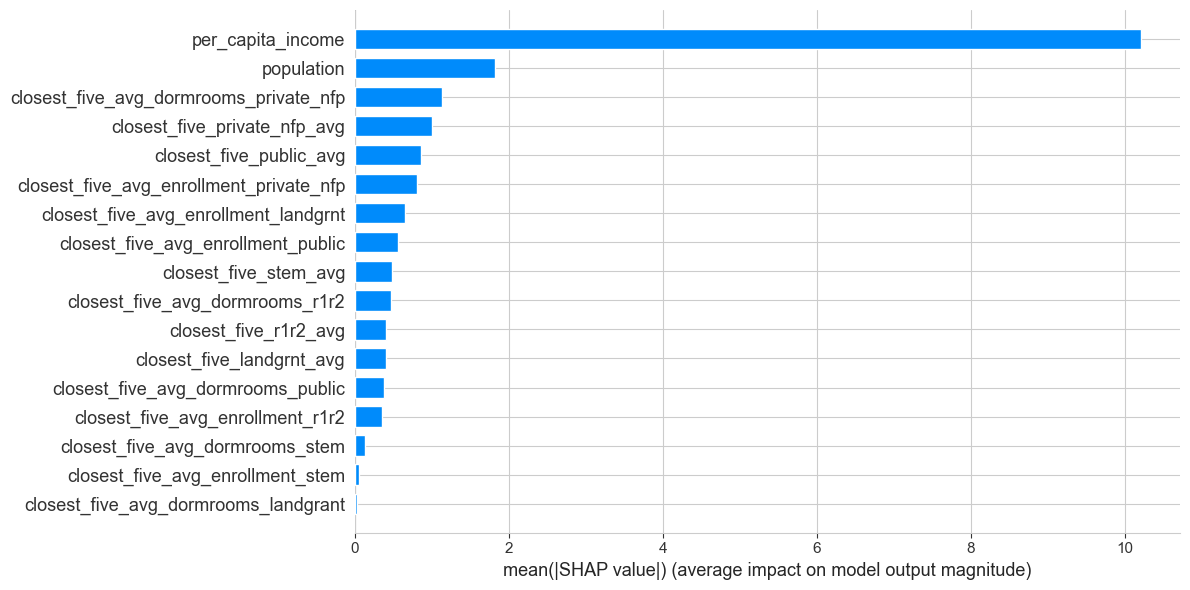

In [62]:
shap.summary_plot(
    shap_values, 
    X_train, 
    plot_type='bar', 
    show=False,
    plot_size=[12, 6]
)
plt.show()
plt.close()

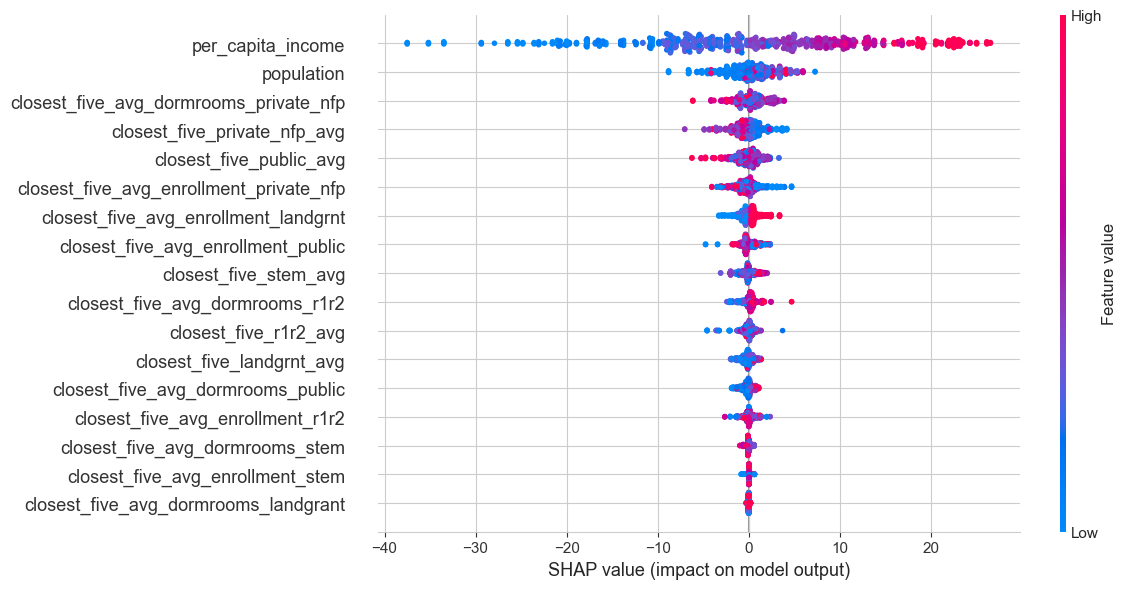

In [63]:
### the scatter plot
shap.summary_plot(shap_values, X_train, show=False, plot_size=[12, 6])
plt.show()
plt.close()

### **And also Random Forest model**

### Since Random Forest model is the model of choice for Massachusetts, we will also save the plots as pickle files.

In [64]:
explainer = shap.TreeExplainer(random_forest)
shap_values = explainer.shap_values(X_train)

In [65]:
# Compute mean absolute SHAP value for each feature
shap_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': np.abs(shap_values).mean(axis=0)
}).sort_values(by='Importance', ascending=False)

print("Feature Importance from SHAP:\n")
print(shap_importance)

Feature Importance from SHAP:

                                    Feature  Importance
1                         per_capita_income   10.154305
0                                population    1.176442
8              closest_five_private_nfp_avg    0.688100
5                   closest_five_public_avg    0.539643
10   closest_five_avg_dormrooms_private_nfp    0.531225
11                closest_five_landgrnt_avg    0.486514
14                    closest_five_stem_avg    0.452869
9   closest_five_avg_enrollment_private_nfp    0.447093
2                     closest_five_r1r2_avg    0.404423
7         closest_five_avg_dormrooms_public    0.301944
3          closest_five_avg_enrollment_r1r2    0.291885
6        closest_five_avg_enrollment_public    0.238593
12     closest_five_avg_enrollment_landgrnt    0.217115
16          closest_five_avg_dormrooms_stem    0.205284
4           closest_five_avg_dormrooms_r1r2    0.125482
13     closest_five_avg_dormrooms_landgrant    0.115333
15         closes

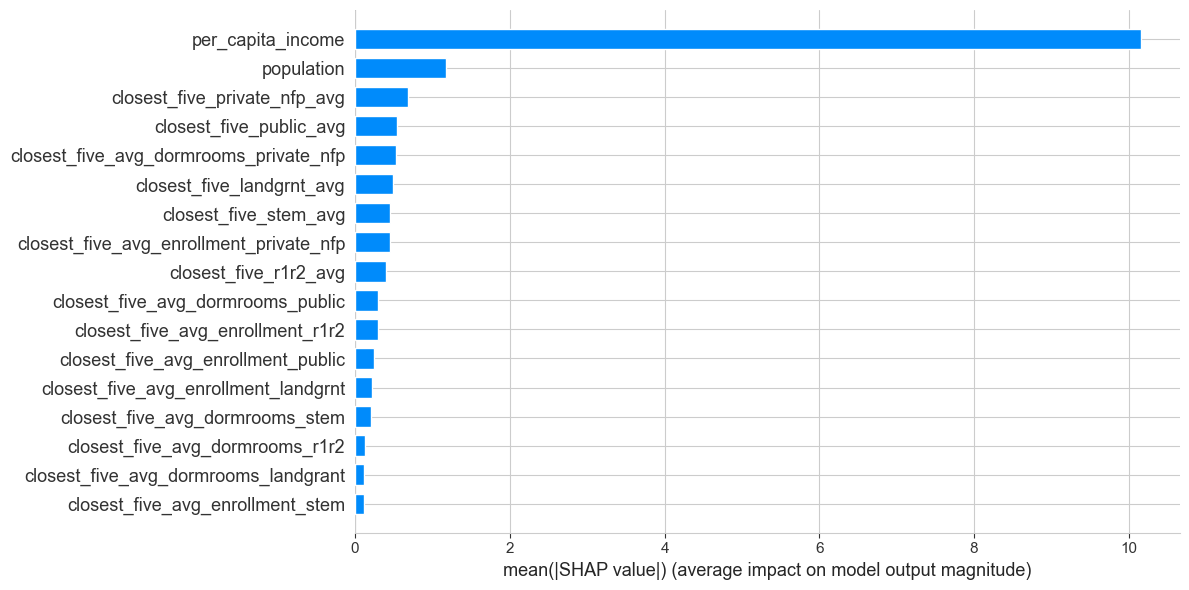

In [66]:
fig = plt.figure()
shap.summary_plot(
    shap_values, 
    X_train, 
    plot_type='bar', 
    show=False,
    plot_size=[12, 6]
)
plt.show(fig)
plt.close()

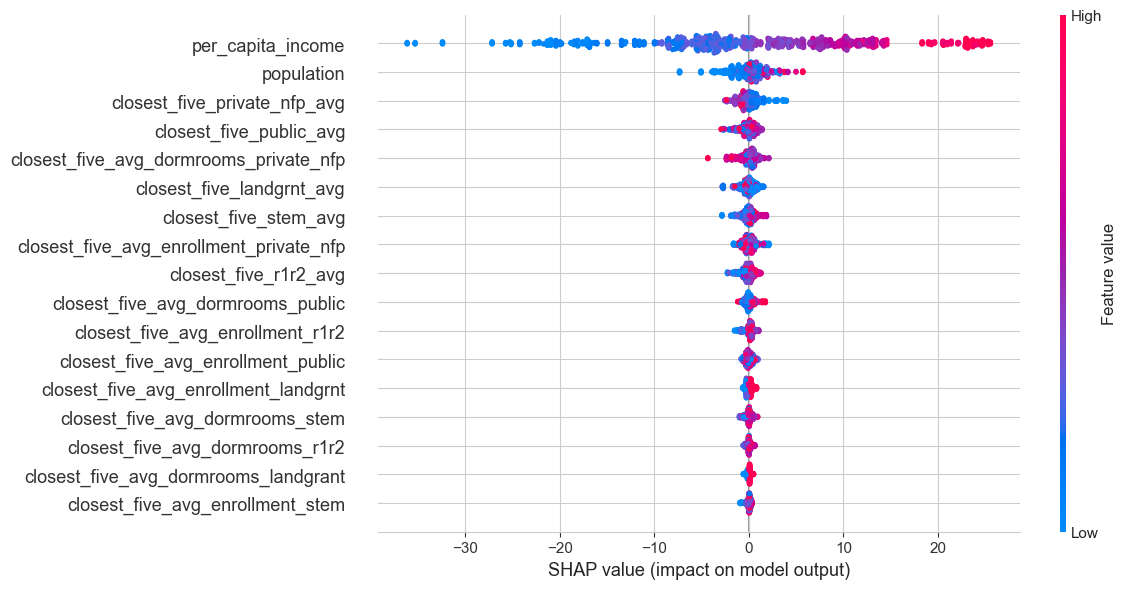

In [67]:
### the scatter plot
fig = plt.figure()
shap.summary_plot(shap_values, X_train, show=False, plot_size=[12, 6])
plt.show(fig)
plt.close()

### As expected, per capita income and population are the two most important features. But the contribution of the other features is not negligible.

# We will now use Random Forest model to make predictions on the testing data.

In [68]:
testing = pd.read_csv('../data/Massachusetts/train_test_split/testing.csv')

In [69]:
preds=random_forest.predict(testing[features])

In [70]:
predictions = testing[['COUNTY','Year','PERCENT_3_OR_ABOVE']]
predictions['Predicted pass rate'] = preds

/var/folders/8x/8t87b_9j1797md982ndxw5580000gq/T/ipykernel_64811/2779204594.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictions['Predicted pass rate'] = preds


In [71]:
predictions

,COUNTY,Year,PERCENT_3_OR_ABOVE,Predicted pass rate
0,Maynard,2022,75.9,64.717349
1,Georgetown,2019,92.2,78.917056
2,Reading,2018,82.5,73.234698
3,Chelsea,2019,56.2,41.135527
4,Nantucket,2018,69.9,56.352674
...,...,...,...,...
217,Marlborough,2018,45.7,45.440358
218,Dennis-Yarmouth,2018,51.7,57.875184
219,Millbury,2018,45.6,54.777829
220,Bellingham,2020,37.2,56.207875


In [72]:
root_mean_squared_error(predictions['Predicted pass rate'],predictions['PERCENT_3_OR_ABOVE']) # Root mean squared error of our predictions.

np.float64(8.619049735756892)

In [73]:
r2_score(predictions['Predicted pass rate'],predictions['PERCENT_3_OR_ABOVE']) # R-squared coefficient of our predictions.

0.6430330724566581